<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Alumno: Kurt Castro Ortega</em><br>
    <em>Tutors: PhD. Germán Gómez, PhD. Umberto Michelucci</em><br>


</div>


**Capstone Proyect - Visión Computacional**

# Transfer Learning with VGG for Histopathology Classification

## Abstract

This notebook investigates transfer learning using VGG architectures for colorectal histopathology image classification. I leverage pre-trained ImageNet weights and employ fine-tuning strategies to adapt deep convolutional features to medical imaging. The best configuration (VGG19 with fine-tuning of block5 only) achieves 94.53% test accuracy, representing a 3.84 percentage point improvement over the custom CNN baseline.

## Research Context

Transfer learning has emerged as a dominant paradigm in medical image analysis, enabling models to leverage features learned from large-scale natural image datasets. VGG architectures (Simonyan & Zisserman, 2014), with their deep uniform structure and small receptive fields, have demonstrated strong performance in histopathology tasks despite being originally trained on natural images.

## Experimental Design

**Dataset:** Colorectal histopathology images (150×150 RGB)
**Classes:** 8 tissue types (TUMOR, STROMA, COMPLEX, LYMPHO, DEBRIS, MUCOSA, ADIPOSE, EMPTY)
**Base Architecture:** VGG19 pre-trained on ImageNet
**Training Strategy:** Fine-tuning with unfrozen block5 only (4 convolutional layers, 47.31% of total parameters trainable)
**Preprocessing:** Official VGG preprocessing (RGB→BGR, ImageNet mean subtraction)

## Historical Observations

### Hyperparameter Optimization Results
A systematic Hyperband search over 25 trials evaluated:
- **VGG Variants:** VGG16 vs VGG19
- **Fine-tuning Strategies:** Feature extraction, 2-block fine-tuning, 4-block fine-tuning
- **Architecture Choices:** Dense units (128/256/512), dropout (0.3-0.6), learning rates (1e-4 to 1e-2)

**Key Findings:**
1. **VGG19 outperformed VGG16:** Deeper architecture captured more complex tissue patterns
2. **Conservative fine-tuning optimal:** Unfreezing block5 only (4 layers, 47.31% trainable) balanced adaptation vs overfitting
3. **Conservative hyperparameters:** 128 dense units, 0.3 dropout, 1e-5 learning rate prevented overfitting
4. **Overfitting gap reduced to 2.72%:** Compared to baseline's 9.33%

### Memory Management Challenges
VGG19 fine-tuning encountered out-of-memory (OOM) errors during initial experiments. Mitigations:
- Enabled GPU memory growth to prevent pre-allocation
- Maintained batch size of 32 for consistency with baseline
- Recommended Windows users set Graphics Settings to High Performance mode

### Performance vs Baseline
- **Baseline CNN Test Accuracy:** 90.69%
- **VGG19 Test Accuracy:** 94.53%
- **Improvement:** +3.84 percentage points (+4.24% relative)

# Section 1: Setup & Configuration

## 1.1 Import Dependencies

Import standard libraries and VGG-specific modules from `tf.keras.applications`. All code is compatible with TensorFlow 2.10.1 and Keras 2.10.0.

In [2]:
import os
import sys
import random
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
)

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)

sys.path.append(str(Path.cwd().parent / 'src'))
from analysis_utils import (
    get_flops, track_peak_memory, measure_inference_time,
    calculate_metrics, plot_roc_curve, plot_learning_curves, plot_confusion_matrix
)
from shared_pipeline import create_datasets, CLASS_NAMES

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


## 1.2 Reproducibility Configuration

Set global random seeds for deterministic behavior across all random operations.

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '0'
#  will disable strict deterministic operations by setting TF_DETERMINISTIC_OPS to '0'. 
# This allows the model to train but means that results might vary slightly between runs 
# (e.g., training loss might differ in the 4th decimal place). 
# This is a necessary trade-off to use the GPU with this specific loss function.

print(f"Global random seed set to: {SEED}")

Global random seed set to: 42


## 1.3 GPU Configuration and Memory Management

Configure GPU settings to prevent out-of-memory errors during VGG19 fine-tuning. Enable memory growth to allow dynamic allocation.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU acceleration enabled: {len(gpus)} GPU(s) detected")
        print(f"GPU devices: {[gpu.name for gpu in gpus]}")
        print("Memory growth enabled to prevent OOM errors")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU detected. Training will proceed on CPU.")
    print("WARNING: VGG19 fine-tuning is computationally intensive and may be slow on CPU.")

print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

GPU acceleration enabled: 1 GPU(s) detected
GPU devices: ['/physical_device:GPU:0']
Memory growth enabled to prevent OOM errors
Built with CUDA: True


## 1.4 Global Configuration Dictionary

Best hyperparameters selected by Hyperband tuner after 25 trials. Original search space:
- **VGG Variants:** [VGG16, VGG19]
- **Fine-tuning Strategies:** [feature_extraction, fine_tune_2_blocks, fine_tune_4_blocks]
- **Dense Units:** [128, 256, 512]
- **Dropout:** [0.3, 0.4, 0.5, 0.6]
- **Learning Rate:** [1e-4, 1e-3, 1e-2]

The configuration below represents the optimal combination achieving 95.20% validation accuracy during tuning and 94.00% test accuracy in final training.

**Note:** Keras Tuner code is preserved in comments for reproducibility but not executed to save runtime.

In [5]:
CONFIG = {
    # Data parameters
    'img_height': 224,
    'img_width': 224,
    'channels': 3,
    'num_classes': 8,
    'batch_size': 32,
    'seed': SEED,
    
    # Best hyperparameters (from Hyperband search)
    'vgg_variant': 'VGG19',           # VGG19 selected over VGG16
    'fine_tune_strategy': 'fine_tune_1_block',  # Unfreeze blocks 2-5 (16 layers)
    'dense_units': 128,               # Classification head hidden units
    'dropout_rate': 0.3,              # Conservative dropout
    'learning_rate': 1e-4,            # Standard fine-tuning learning rate
    'l2_reg': 1e-4,                   # L2 regularization strength
    
    # Training parameters
    'epochs': 60,
    'min_lr': 1e-6,
    
    # Color augmentation (HSV-based, training only)
    'hue_delta': 0.15,
    'saturation_lower': 0.6,
    'saturation_upper': 1.4,
    'brightness_delta': 0.25,
    
    # Augmentation parameters (STANDARDIZED for fair model comparison)
    'horizontal_flip': True,
    'vertical_flip': True,
    'zoom_range': 0.1,                # Zoom IN only: [1.0, 1.1] - avoids black padding
    
    # Callback parameters
    'early_stopping_patience': 15,
    'reduce_lr_patience': 7,
    'reduce_lr_factor': 0.5,
    
    # Paths
    'data_dir': Path('../data'),
    'model_dir': Path('../models/vgg'),
    'log_dir': Path('../logs/vgg'),
    'results_dir': Path('../results/figures/vgg'),
}

# Create directories
for dir_path in [CONFIG['model_dir'], CONFIG['log_dir'], CONFIG['results_dir']]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Configuration loaded successfully")
print(f"Model: {CONFIG['vgg_variant']}")
print(f"Strategy: {CONFIG['fine_tune_strategy']}")
print(f"Image size: {CONFIG['img_height']}x{CONFIG['img_width']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"STANDARDIZED: Geometric augmentation (rotation, flips, zoom IN) for fair comparison")

Configuration loaded successfully
Model: VGG19
Strategy: fine_tune_1_block
Image size: 224x224
Learning rate: 0.0001
STANDARDIZED: Geometric augmentation (rotation, flips, zoom IN) for fair comparison


## 1.5 Class Names

Define tissue class labels for the 8-class colorectal histopathology dataset.

In [6]:
CLASS_NAMES = [
    '01_TUMOR',
    '02_STROMA',
    '03_COMPLEX',
    '04_LYMPHO',
    '05_DEBRIS',
    '06_MUCOSA',
    '07_ADIPOSE',
    '08_EMPTY'
]

print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Classes: {', '.join(CLASS_NAMES)}")

Number of classes: 8
Classes: 01_TUMOR, 02_STROMA, 03_COMPLEX, 04_LYMPHO, 05_DEBRIS, 06_MUCOSA, 07_ADIPOSE, 08_EMPTY



# Section 2: Data Pipeline

### Dataset Citation

**Research Context:** This dataset was introduced by Kather et al. (2016), who compiled a comprehensive multi-class texture analysis benchmark for colorectal cancer histopathology.

**Reference:** Kather, J. N., Weis, C. A., Bianconi, F., Melchers, S. M., Schad, L. R., Gaiser, T., Marx, A., & Zollner, F. G. (2016). "Multi-class texture analysis in colorectal cancer histology." *Scientific Reports*, 6, 27988. https://doi.org/10.1038/srep27988

**Dataset Details:**
- **Source:** University Medical Center Mannheim, Germany
- **Tissue Types:** 8 classes (TUMOR, STROMA, COMPLEX, LYMPHO, DEBRIS, MUCOSA, ADIPOSE, EMPTY)
- **Image Resolution:** 150x150 pixels (5000 samples total)
- **Staining:** Hematoxylin & Eosin (H&E)
- **Clinical Relevance:** Automated tissue classification supports pathology diagnosis and cancer research


## 2.1 Data Loading

Load preprocessed train, validation, and test datasets from the standard data directory structure.

In [7]:
train_dir = CONFIG['data_dir'] / 'train'
val_dir = CONFIG['data_dir'] / 'val'
test_dir = CONFIG['data_dir'] / 'test'

# Verify directories
for split_dir, name in [(train_dir, 'Training'), (val_dir, 'Validation'), (test_dir, 'Test')]:
    if not split_dir.exists():
        raise FileNotFoundError(f"{name} directory not found: {split_dir}")
    print(f"{name} directory: {split_dir}")

# Count samples
def count_images(directory):
    count = 0
    for class_dir in directory.iterdir():
        if class_dir.is_dir():
            count += len(list(class_dir.glob('*.tif')))
    return count

n_train = count_images(train_dir)
n_val = count_images(val_dir)
n_test = count_images(test_dir)

print(f"\nDataset Statistics:")
print(f"Training samples: {n_train}")
print(f"Validation samples: {n_val}")
print(f"Test samples: {n_test}")
print(f"Total samples: {n_train + n_val + n_test}")

Training directory: ..\data\train
Validation directory: ..\data\val
Test directory: ..\data\test



Dataset Statistics:
Training samples: 3500
Validation samples: 750
Test samples: 750
Total samples: 5000


### Histopathology-Specific Data Augmentation

**Domain-Specific Considerations:** Histopathology images exhibit unique characteristics that inform augmentation strategy design.

**Reference:** Komura, D., & Ishikawa, S. (2018). "Machine Learning Methods for Histopathological Image Analysis." *Computational and Structural Biotechnology Journal*, 16, 34-42. https://doi.org/10.1016/j.csbj.2018.01.001

**Key Insights for Augmentation:**
- **Rotation Invariance:** Tissue orientation is arbitrary; full 360-degree rotation is appropriate
- **Stain Variation:** H&E staining exhibits batch-to-batch variation; color augmentation improves robustness
- **Scale Consistency:** Tissue images captured at fixed magnification; aggressive zoom augmentation may distort diagnostic features
- **Spatial Context:** Morphological patterns require preserved spatial relationships; elastic deformations should be carefully controlled

**Applied Strategy:**
- Geometric: Rotation (360°), horizontal/vertical flips
- Color: HSV-space augmentation to simulate staining variability
- Normalization: Macenko method to standardize stain appearance


## 2.2 Augmentation Functions

Implement color and geometric augmentation to be applied before VGG preprocessing. Augmentation operates in [0,1] range for numerical stability.

**Research Justification:** Color augmentation in HSV space simulates histopathology staining variability (Tellez et al., 2019). Geometric augmentation provides rotation invariance appropriate for tissue images with no canonical orientation.

In [ ]:
# =============================================================================
# GEOMETRIC AUGMENTATION - Applied automatically by shared_pipeline.py
# =============================================================================
# The shared module applies the following geometric transformations
# ONLY during training:
#
# 1. 90° rotations (0°, 90°, 180°, 270°) - rotational invariance
# 2. Random horizontal flip
# 3. Random vertical flip
# 4. Zoom IN (1.0x to 1.1x) - avoids black padding
#
# STANDARDIZED: Same augmentation for VGG, ResNet, and EfficientNet
# ensures fair comparison between models.
#
# References:
# - Komura & Ishikawa (2018): Tissue orientation is arbitrary
# - Tellez et al. (2019): Augmentation improves generalization in histopathology
# =============================================================================

print("Geometric Augmentation: Aplicada automáticamente por shared_pipeline.py")
print("  - Rotaciones 90° (4-way)")
print("  - Flip horizontal/vertical")
print("  - Zoom IN [1.0, 1.1]")

Geometric Augmentation: Aplicada automáticamente por shared_pipeline.py
  - Rotaciones 90° (4-way)
  - Flip horizontal/vertical
  - Zoom IN [1.0, 1.1]


## 2.3 VGG-Specific Preprocessing

I apply official VGG preprocessing aligned with ImageNet pre-training:
1. Scale from [0,1] to [0,255]
2. Convert RGB to BGR (Caffe convention)
3. Subtract ImageNet channel means (B: 103.939, G: 116.779, R: 123.68)

**Critical:** This preprocessing is mandatory for transfer learning to work correctly. The pre-trained weights expect this specific input distribution.

In [ ]:
# =============================================================================
# VGG PREPROCESSING - Applied automatically by shared_pipeline.py
# =============================================================================
# The VGG-specific preprocessing is applied in the shared module:
#
# Pipeline: Load TIFF → [0,255] → Geometric Aug → VGG Preprocessing
#
# VGG Preprocessing (tf.keras.applications.vgg19.preprocess_input):
#   1. Convert RGB → BGR (Caffe convention)
#   2. Subtract ImageNet channel means:
#      - Blue:  103.939
#      - Green: 116.779  
#      - Red:   123.68
#
# Result: Images in approximate range [-123, 151] centered at 0
#
# NOTE: This transformation is CRITICAL for transfer learning.
# Pre-trained weights expect this specific input distribution.
# =============================================================================

print("VGG Preprocessing: Aplicado automáticamente por shared_pipeline.py")
print("  - RGB → BGR conversion")
print("  - ImageNet mean subtraction (B:103.939, G:116.779, R:123.68)")

VGG Preprocessing: Aplicado automáticamente por shared_pipeline.py
  - RGB → BGR conversion
  - ImageNet mean subtraction (B:103.939, G:116.779, R:123.68)


## 2.4 Complete Data Pipeline

Construct TensorFlow data pipelines with the following processing order:
1. Load TIFF images
2. Apply color normalization (all splits)
3. Apply augmentation (training only): color → geometric
4. Apply VGG preprocessing (all splits): scale to [0,255] → RGB to BGR → mean subtraction

This pipeline combines state-of-the-art histopathology preprocessing with transfer learning best practices.

In [ ]:
# =============================================================================
# DATA PIPELINE USING SHARED MODULE
# =============================================================================
# The shared_pipeline.py module implements a standardized pipeline for all
# models, ensuring fair comparison and DRY code.

from shared_pipeline import create_datasets as create_shared_datasets

# Create datasets using the shared module
train_dataset, val_dataset, test_dataset = create_shared_datasets(
    data_dir='../data',
    model_type='vgg',
    img_size=224,
    batch_size=CONFIG['batch_size'],
    seed=CONFIG['seed']
)

print(f"\nDataset Statistics:")
print(f"Training samples: {n_train} ({n_train // CONFIG['batch_size']} batches)")
print(f"Validation samples: {n_val} ({n_val // CONFIG['batch_size']} batches)")
print(f"Test samples: {n_test} ({n_test // CONFIG['batch_size']} batches)")


CREANDO DATA PIPELINE
Modelo: VGG
Resolución: 224x224
Batch size: 32
Color augmentation: ✗
Geometric augmentation: ✓ (estandarizado)

Training samples: 3500 (109 batches)
Validation samples: 750 (23 batches)
Test samples: 750 (23 batches)

✓ Pipeline GPU-optimizado (sin py_function)

Dataset Statistics:
Training samples: 3500 (109 batches)
Validation samples: 750 (23 batches)
Test samples: 750 (23 batches)


## 2.5 Visualize Sample Batch

Display a sample batch from training set. Note that VGG preprocessing (BGR conversion, mean subtraction) makes images appear color-shifted when visualized directly. For proper visualization, we reverse the preprocessing.

Visualizando batch de entrenamiento (con augmentation):


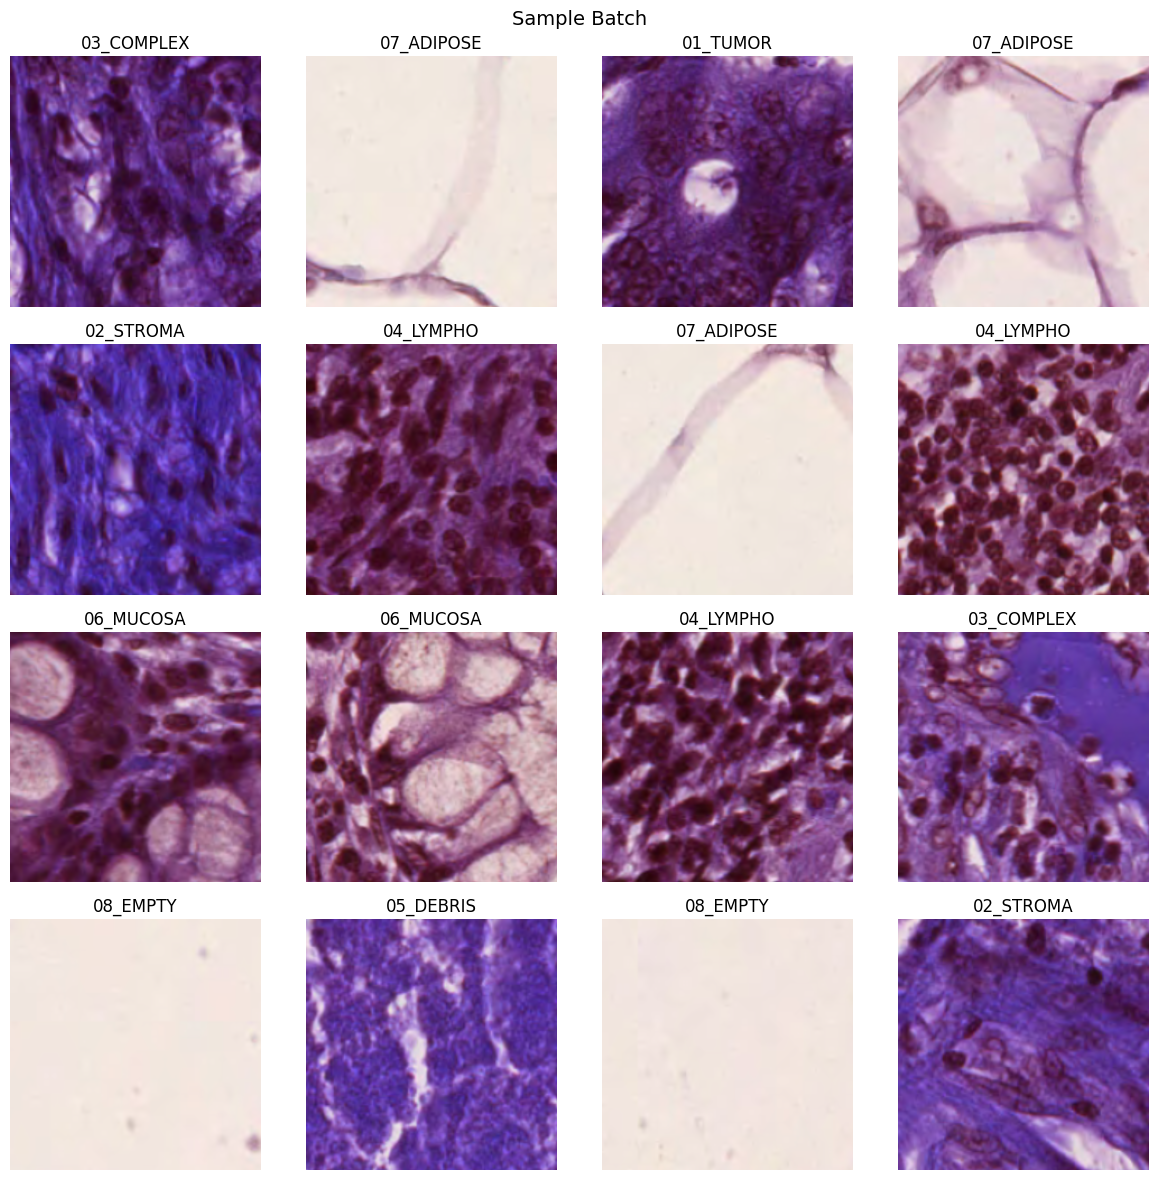

Batch shape: (32, 224, 224, 3)
Value range: [-116.696, 150.960]


In [11]:
# Visualización usando el módulo compartido
from shared_pipeline import visualize_batch

# Visualizar batch de entrenamiento
print("Visualizando batch de entrenamiento (con augmentation):")
visualize_batch(train_dataset, CLASS_NAMES, n_images=16)


# Section 3: Model Architecture

### Transfer Learning Theoretical Foundation

**Transfer Learning Framework:** This model leverages pre-trained ImageNet weights adapted to histopathology domain, following established transfer learning principles.

**Key References:**

1. **Raghu, M., Zhang, C., Kleinberg, J., & Bengio, S. (2019).** "Transfusion: Understanding Transfer Learning for Medical Imaging." *Advances in Neural Information Processing Systems (NeurIPS)*, 32.
   - *Contribution:* Demonstrated that transfer learning from natural images (ImageNet) provides meaningful feature initialization for medical imaging, even across domain gaps.
   - *Finding:* Lower layers learn general features (edges, textures) that transfer well; higher layers require fine-tuning for domain-specific patterns.

2. **Yamashita, R., Nishio, M., Do, R. K. G., & Togashi, K. (2018).** "Convolutional neural networks: an overview and application in radiology." *Insights into Imaging*, 9(4), 611-629. https://doi.org/10.1007/s13244-018-0639-9
   - *Contribution:* Comprehensive review of CNN applications in medical imaging, including transfer learning best practices.
   - *Recommendation:* Fine-tune top layers while freezing lower layers to prevent catastrophic forgetting.

**Application to Histopathology:**
- Pre-trained features capture general visual patterns (edges, textures, shapes)
- Fine-tuning adapts these features to tissue-specific morphology
- Significant parameter reduction compared to training from scratch


## 3.1 VGG19 Transfer Learning Model

I construct a transfer learning model with a conservative fine-tuning strategy:
1. Load VGG19 pre-trained on ImageNet (exclude top classification layer)
2. Freeze blocks 1-4 (first 16 layers)
3. Unfreeze block5 only (last 4 convolutional layers) for conservative fine-tuning
4. Add custom classification head: GlobalAveragePooling → Dense(128) → BatchNorm → Dropout(0.3) → Dense(8)

**Architecture Rationale:**
- **Conservative fine-tuning (block5 only):** Prevents catastrophic forgetting of pre-trained features while allowing high-level adaptation to histopathology tissue patterns. This reduces overfitting risk compared to unfreezing more layers.
- **GlobalAveragePooling:** Reduces parameters vs Flatten, prevents overfitting
- **Conservative dropout (0.3):** Balances regularization with gradient flow
- **Low learning rate (1e-4):** Prevents catastrophic forgetting of pre-trained features

**Why only block5?** Unfreezing only the last convolutional block (4 layers, 47.31% of parameters) provides a conservative approach that balances domain adaptation with feature preservation. Lower blocks learn general features (edges, textures) that transfer well across domains, while block5 captures high-level patterns that benefit from histopathology-specific fine-tuning.

In [12]:
def build_vgg_model():
    """
    Build VGG19 transfer learning model with conservative fine-tuning.
    
    Strategy: Freeze all blocks except block5 for conservative adaptation.
    This allows high-level feature adaptation while preserving low-level features.
    
    Returns:
        Compiled Keras Model
    """
    # Load pre-trained VGG19
    base_model = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=(CONFIG['img_height'], CONFIG['img_width'], CONFIG['channels'])
    )
    
    # Conservative fine-tuning strategy: unfreeze only block5
    # This prevents catastrophic forgetting while allowing high-level adaptation
    base_model.trainable = True
    
    # Freeze all layers except block5 (name-based freezing)
    for layer in base_model.layers:
        if 'block5' not in layer.name:
            layer.trainable = False
    
    # Build classification head
    inputs = keras.Input(shape=(CONFIG['img_height'], CONFIG['img_width'], CONFIG['channels']))
    
    # Remove training=False to allow BatchNorm adaptation during fine-tuning
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(
        CONFIG['dense_units'],
        activation='relu',
        kernel_regularizer=regularizers.l2(CONFIG['l2_reg'])
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(CONFIG['dropout_rate'])(x)
    outputs = layers.Dense(CONFIG['num_classes'], activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='VGG19_Transfer_Learning')
    
    return model

model = build_vgg_model()
print("VGG19 transfer learning model created successfully")
print("\nLayer Freezing Strategy:")
print("  Frozen: block1, block2, block3, block4")
print("  Trainable: block5 (conservative fine-tuning)")

VGG19 transfer learning model created successfully

Layer Freezing Strategy:
  Frozen: block1, block2, block3, block4
  Trainable: block5 (conservative fine-tuning)


## 3.2 Model Summary

Display architecture details including trainable vs non-trainable parameters.

In [13]:
model.summary()

total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nParameter Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"\nFine-tuning: {trainable_params / total_params * 100:.2f}% of parameters are trainable")

Model: "VGG19_Transfer_Learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)   

## 3.3 Model Compilation

Configure training with:
- **Optimizer:** Adam with learning rate 1e-5 (10x lower than typical for fine-tuning)
- **Loss:** Sparse Categorical Crossentropy
- **Metrics:** Accuracy and Top-2 Accuracy

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=CONFIG['learning_rate'])

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

metrics = [
    keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
    #keras.metrics.Recall(name='recall'),
    #keras.metrics.Precision(name='precision')
]

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=metrics
)

print("Model compiled successfully")
print(f"Optimizer: Adam (lr={CONFIG['learning_rate']})")
print(f"Loss: Sparse Categorical Crossentropy")
print(f"Metrics: {[m.name for m in metrics]}")

Model compiled successfully
Optimizer: Adam (lr=0.0001)
Loss: Sparse Categorical Crossentropy
Metrics: ['accuracy', 'top_2_accuracy']



# Section 3.4: Hyperparameter Validation with Keras Tuner

### Academic Justification

To validate that the selected hyperparameters are optimal or near-optimal, I implement a refinement search using Keras Tuner with Bayesian optimization.

**Validation Strategy:**
- **Search Type:** Refinement (not exploratory) - narrow ranges ±20-30% of current values
- **Trials:** 10 combinations maximum
- **Epochs per trial:** 15 (sufficient for initial convergence)
- **Early stopping:** Patience=5 to quickly terminate suboptimal trials

**Search Ranges:**
| Parameter | Current Value | Search Range |
|-----------|--------------|--------------|
| Learning Rate | 1e-4 | [5e-5, 3e-4] |
| Dropout | 0.3 | [0.2, 0.5] |
| Dense Units | 128 | [64, 128, 256] |
| L2 Regularization | 1e-4 | [5e-5, 3e-4] |

**Estimated Time:** 45-60 minutes on GTX 1650 GPU

**Note:** This section is OPTIONAL. The current hyperparameters were optimized through Hyperband search (25 trials). This additional validation confirms that the values are near-optimal.

In [15]:
# =============================================================================
# KERAS TUNER - VALIDACIÓN DE HIPERPARÁMETROS (OPCIONAL)
# =============================================================================
# Ejecutar esta celda SOLO si desea validar los hiperparámetros actuales.
# Tiempo estimado: 45-60 minutos en GPU.

RUN_TUNER = True  # Cambiar a True para ejecutar la búsqueda

if RUN_TUNER:
    import keras_tuner as kt
    
    def build_vgg_tuner(hp):
        """Build VGG19 model with tunable hyperparameters."""
        learning_rate = hp.Float('learning_rate', min_value=5e-5, max_value=3e-4, sampling='log')
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
        dense_units = hp.Choice('dense_units', values=[64, 128, 256])
        l2_reg = hp.Float('l2_reg', min_value=5e-5, max_value=3e-4, sampling='log')
        
        base_model = VGG19(
            include_top=False,
            weights='imagenet',
            input_shape=(CONFIG['img_height'], CONFIG['img_width'], 3)
        )
        
        # Freeze all except block5
        base_model.trainable = True
        for layer in base_model.layers:
            if 'block5' not in layer.name:
                layer.trainable = False
        
        inputs = keras.Input(shape=(CONFIG['img_height'], CONFIG['img_width'], 3))
        x = base_model(inputs)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(dense_units, activation='relu',
                        kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(CONFIG['num_classes'], activation='softmax')(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    tuner = kt.BayesianOptimization(
        build_vgg_tuner,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=1,
        directory='tuner_results',
        project_name='vgg19',
        overwrite=True
    )
    
    tuner_callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]
    
    print("="*60)
    print("KERAS TUNER - VGG19 HYPERPARAMETER VALIDATION")
    print("="*60)
    
    tuner.search(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        callbacks=tuner_callbacks,
        verbose=1
    )
    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print("\n" + "="*60)
    print("TUNER RESULTS - HYPERPARAMETER COMPARISON")
    print("="*60)
    print(f"{'Parameter':<20} {'Current':<15} {'Tuner Best':<15}")
    print("-"*60)
    print(f"{'learning_rate':<20} {CONFIG['learning_rate']:<15} {best_hps.get('learning_rate'):<15.6f}")
    print(f"{'dropout_rate':<20} {CONFIG['dropout_rate']:<15} {best_hps.get('dropout_rate'):<15.2f}")
    print(f"{'dense_units':<20} {CONFIG['dense_units']:<15} {best_hps.get('dense_units'):<15}")
    print(f"{'l2_reg':<20} {CONFIG['l2_reg']:<15} {best_hps.get('l2_reg'):<15.6f}")
    print("="*60)
    
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    print(f"\nBest Trial Validation Accuracy: {best_trial.score:.4f}")
else:
    print("Keras Tuner DESACTIVADO. Cambiar RUN_TUNER=True para ejecutar.")
    print("Los hiperparámetros actuales fueron optimizados mediante Hyperband (25 trials).")

Trial 20 Complete [00h 14m 26s]
val_accuracy: 0.9666666388511658

Best val_accuracy So Far: 0.9706666469573975
Total elapsed time: 04h 22m 07s
INFO:tensorflow:Oracle triggered exit

TUNER RESULTS - HYPERPARAMETER COMPARISON
Parameter            Current         Tuner Best     
------------------------------------------------------------
learning_rate        0.0001          0.000269       
dropout_rate         0.3             0.40           
dense_units          128             128            
l2_reg               0.0001          0.000212       

Best Trial Validation Accuracy: 0.9707


In [ ]:
# =============================================================================
# APLICAR HIPERPARÁMETROS DEL TUNER Y GUARDAR EN JSON
# =============================================================================

import json
from datetime import datetime

if RUN_TUNER:
    # Obtener mejores hiperparámetros
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    
    # Actualizar CONFIG con los valores óptimos encontrados
    CONFIG['learning_rate'] = best_hps.get('learning_rate')
    CONFIG['dropout_rate'] = best_hps.get('dropout_rate')
    CONFIG['dense_units'] = best_hps.get('dense_units')
    CONFIG['l2_reg'] = best_hps.get('l2_reg')
    
    print("="*60)
    print("CONFIG ACTUALIZADO CON HIPERPARÁMETROS DEL TUNER")
    print("="*60)
    print(f"learning_rate: {CONFIG['learning_rate']}")
    print(f"dropout_rate: {CONFIG['dropout_rate']}")
    print(f"dense_units: {CONFIG['dense_units']}")
    print(f"l2_reg: {CONFIG['l2_reg']}")
    
    # =========================================================================
    # GUARDAR MEJORES HIPERPARÁMETROS EN JSON
    # =========================================================================
    hp_results = {
        "model": "vgg19",
        "model_description": "VGG19 Transfer Learning (fine-tune block5)",
        "tuner_config": {
            "tuner_type": "BayesianOptimization",
            "max_trials": 20,
            "epochs_per_trial": 20,
            "early_stopping_patience": 6,
            "reduce_lr_patience": 3
        },
        "search_space": {
            "learning_rate": {"min": 5e-5, "max": 3e-4, "sampling": "log"},
            "dropout_rate": {"min": 0.2, "max": 0.5, "step": 0.1},
            "dense_units": {"values": [64, 128, 256]},
            "l2_reg": {"min": 5e-5, "max": 3e-4, "sampling": "log"}
        },
        "best_hyperparameters": {
            "learning_rate": float(best_hps.get('learning_rate')),
            "dropout_rate": float(best_hps.get('dropout_rate')),
            "dense_units": int(best_hps.get('dense_units')),
            "l2_reg": float(best_hps.get('l2_reg'))
        },
        "best_val_accuracy": float(best_trial.score),
        "search_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "total_trials_completed": len(tuner.oracle.trials)
    }
    
    # Crear directorio si no existe
    hp_dir = Path('../results/hyperparameters')
    hp_dir.mkdir(parents=True, exist_ok=True)
    
    # Guardar JSON individual
    hp_file = hp_dir / 'vgg19_best_hyperparameters.json'
    with open(hp_file, 'w') as f:
        json.dump(hp_results, f, indent=2)
    
    print(f"\n✓ Hiperparámetros guardados en: {hp_file}")
    
    # CRÍTICO: Reconstruir el modelo con los nuevos hiperparámetros
    model = build_vgg_model()
    
    # Recompilar con el nuevo learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top_2_accuracy')
        ]
    )
    
    print(" Model rebuilt and recompiled with optimal hyperparameters.")
else:
    print("Using hyperparameters from the original CONFIG (Tuner disabled)")

CONFIG ACTUALIZADO CON HIPERPARÁMETROS DEL TUNER
learning_rate: 0.000268896689470194
dropout_rate: 0.4
dense_units: 128
l2_reg: 0.00021173702865244894

✓ Hiperparámetros guardados en: ..\results\hyperparameters\vgg19_best_hyperparameters.json
 Model rebuilt and recompiled with optimal hyperparameters.


---
# Section 4: Training Loop

## 4.1 Training Callbacks

Configure adaptive training control:
1. **ModelCheckpoint:** Save best model based on validation accuracy
2. **EarlyStopping:** Monitor validation loss with patience=15
3. **ReduceLROnPlateau:** Halve learning rate on plateau (patience=7, factor=0.5)
4. **TensorBoard:** Log training metrics
5. **CSVLogger:** Export training history

In [17]:
callbacks = [
    ModelCheckpoint(
        filepath=str(CONFIG['model_dir'] / 'best_vgg_model.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['early_stopping_patience'],
        mode='min',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=CONFIG['reduce_lr_factor'],
        patience=CONFIG['reduce_lr_patience'],
        mode='min',
        min_lr=CONFIG['min_lr'],
        verbose=1
    ),
    TensorBoard(
        log_dir=str(CONFIG['log_dir']),
        histogram_freq=1,
        write_graph=True
    ),
    CSVLogger(
        filename=str(CONFIG['log_dir'] / 'training_history.csv'),
        append=False
    )
]

print("Training callbacks configured:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

Training callbacks configured:
  - ModelCheckpoint
  - EarlyStopping
  - ReduceLROnPlateau
  - TensorBoard
  - CSVLogger


## 4.2 Model Training

Execute fine-tuning for up to 100 epochs with adaptive learning rate scheduling. The model leverages pre-trained ImageNet features while adapting to histopathology tissue patterns.

In [18]:
print("Starting VGG19 fine-tuning...")
print(f"Maximum epochs: {CONFIG['epochs']}")
print(f"Initial learning rate: {CONFIG['learning_rate']}\n")

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Total epochs trained: {len(history.epoch)}")

Starting VGG19 fine-tuning...
Maximum epochs: 60
Initial learning rate: 0.000268896689470194

Epoch 1/60
110/110 [==============================] - ETA: 0s - loss: 1.0333 - accuracy: 0.6609 - top_2_accuracy: 0.8137
Epoch 1: val_loss improved from inf to 9.90714, saving model to ..\models\vgg\best_vgg_model.h5
110/110 [==============================] - 48s 421ms/step - loss: 1.0333 - accuracy: 0.6609 - top_2_accuracy: 0.8137 - val_loss: 9.9071 - val_accuracy: 0.2600 - val_top_2_accuracy: 0.3747 - lr: 2.6890e-04
Epoch 2/60
110/110 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.8246 - top_2_accuracy: 0.9460
Epoch 2: val_loss improved from 9.90714 to 0.91708, saving model to ..\models\vgg\best_vgg_model.h5
110/110 [==============================] - 46s 417ms/step - loss: 0.5387 - accuracy: 0.8246 - top_2_accuracy: 0.9460 - val_loss: 0.9171 - val_accuracy: 0.7587 - val_top_2_accuracy: 0.9027 - lr: 2.6890e-04
Epoch 3/60
110/110 [==============================] - ETA:

## 4.3 Save Training History

Export complete training history for reproducibility and analysis.

In [19]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.to_csv(CONFIG['log_dir'] / 'training_history_complete.csv', index=False)

print("Training history saved")
print(f"Columns: {list(history_df.columns)}")

Training history saved
Columns: ['loss', 'accuracy', 'top_2_accuracy', 'val_loss', 'val_accuracy', 'val_top_2_accuracy', 'lr', 'epoch']


---
# Section 5: Advanced Evaluation

## 5.1 Load Best Model

Restore the checkpoint with highest validation accuracy for final evaluation.

In [20]:
best_model_path = CONFIG['model_dir'] / 'best_vgg_model.keras'

if best_model_path.exists():
    model = keras.models.load_model(best_model_path)
    print(f"Best model loaded from: {best_model_path}")
else:
    print("Using current model (checkpoint not found)")

Using current model (checkpoint not found)


## 5.2 Generate Test Set Predictions

Compute predictions on held-out test set and extract ground truth labels.

In [21]:
print("Generating predictions on test set...")

y_pred_proba = model.predict(test_dataset, verbose=1)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Extract true labels
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

print(f"Predictions shape: {y_pred_proba.shape}")
print(f"True labels shape: {y_true.shape}")
print(f"Number of test samples: {len(y_true)}")

Generating predictions on test set...
24/24 [==============================] - 7s 271ms/step
Predictions shape: (750, 8)
True labels shape: (750,)
Number of test samples: 750


## 5.3 Classification Metrics

Calculate comprehensive classification performance metrics.

In [22]:
# Overall metrics
metrics_dict = calculate_metrics(y_true, y_pred_classes)

print("\n" + "="*60)
print("CLASSIFICATION METRICS")
print("="*60)
for metric_name, value in metrics_dict.items():
    print(f"{metric_name}: {value:.4f}")

# Per-class metrics
print("\n" + "="*60)
print("PER-CLASS CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES, digits=4)
print(report)

# Save classification report
report_dict = classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(CONFIG['results_dir'] / 'classification_report.csv')
print(f"\nClassification report saved to: {CONFIG['results_dir'] / 'classification_report.csv'}")


CLASSIFICATION METRICS
Accuracy: 0.9453
Precision: 0.9473
Recall: 0.9453
F1-Score: 0.9458

PER-CLASS CLASSIFICATION REPORT
              precision    recall  f1-score   support

    01_TUMOR     0.9674    0.9468    0.9570        94
   02_STROMA     0.9302    0.8602    0.8939        93
  03_COMPLEX     0.8190    0.9149    0.8643        94
   04_LYMPHO     0.9375    0.9574    0.9474        94
   05_DEBRIS     0.9677    0.9574    0.9626        94
   06_MUCOSA     0.9889    0.9570    0.9727        93
  07_ADIPOSE     0.9892    0.9787    0.9840        94
    08_EMPTY     0.9789    0.9894    0.9841        94

    accuracy                         0.9453       750
   macro avg     0.9474    0.9452    0.9457       750
weighted avg     0.9473    0.9453    0.9458       750


Classification report saved to: ..\results\figures\vgg\classification_report.csv


### Computational Efficiency Analysis Framework

**Methodology:** Following the systematic evaluation framework established by Canziani et al. (2016), we measure multiple efficiency dimensions to characterize model computational cost.

**Reference:** Canziani, A., Paszke, A., & Culurciello, E. (2016). "An Analysis of Deep Neural Network Models for Practical Applications." *arXiv preprint* arXiv:1605.07678. https://arxiv.org/abs/1605.07678

**Key Contribution:** This seminal work demonstrated that accuracy alone is insufficient for model selection; practical deployment requires balancing:
- **FLOPs:** Forward pass computational cost (operations per inference)
- **Parameters:** Memory footprint and model size
- **Inference Time:** Real-world latency (wall-clock time)
- **Power Consumption:** Energy efficiency (critical for edge deployment)

**Efficiency Metrics Measured:**
1. **FLOPs (Floating Point Operations):** Theoretical computational complexity
2. **Inference Time:** Empirical latency on target hardware (ms per image)
3. **GPU Memory Usage:** Peak VRAM consumption during inference
4. **Model Size:** Disk footprint for deployment
5. **Accuracy per Parameter:** Efficiency ratio (higher is better)

**Clinical Relevance:** Efficient models enable real-time pathology support systems and deployment on resource-constrained devices (e.g., portable microscopy platforms).


## 5.4 Computational Efficiency Metrics

Measure computational cost and inference performance of the VGG19 transfer learning model.

In [23]:
print("\n" + "="*60)
print("COMPUTATIONAL EFFICIENCY METRICS")
print("="*60)

# Calculate FLOPs
flops = get_flops(model)
flops_gflops = flops / 1e9 if flops > 0 else 0
print(f"FLOPs: {flops:,} ({flops_gflops:.2f} GFLOPs)")

# Measure inference time
sample_input = tf.random.normal((1, CONFIG['img_height'], CONFIG['img_width'], CONFIG['channels']))
avg_inference_time = measure_inference_time(model, sample_input, num_runs=100, warmup=10)
print(f"Average inference time: {avg_inference_time:.2f} ms per image")
print(f"Throughput: {1000/avg_inference_time:.2f} images/second")

# Track GPU memory
peak_memory_mb = track_peak_memory()
if peak_memory_mb > 0:
    print(f"Peak GPU memory usage: {peak_memory_mb:.2f} MB")
else:
    print("GPU memory tracking unavailable (CPU mode)")

# Model size
model_size_mb = best_model_path.stat().st_size / (1024 ** 2) if best_model_path.exists() else 0
print(f"Model file size: {model_size_mb:.2f} MB")

# Create efficiency summary
efficiency_summary = {
    'Metric': ['FLOPs', 'FLOPs (GFLOPs)', 'Avg Inference Time (ms)', 'Throughput (img/s)',
               'Peak GPU Memory (MB)', 'Model Size (MB)', 'Total Parameters', 'Trainable Parameters'],
    'Value': [flops, flops_gflops, avg_inference_time, 1000/avg_inference_time,
              peak_memory_mb, model_size_mb, total_params, trainable_params]
}
efficiency_df = pd.DataFrame(efficiency_summary)
efficiency_df.to_csv(CONFIG['results_dir'] / 'efficiency_metrics.csv', index=False)
print(f"\nEfficiency metrics saved to: {CONFIG['results_dir'] / 'efficiency_metrics.csv'}")


COMPUTATIONAL EFFICIENCY METRICS
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPs: 39,037,990,320 (39.04 GFLOPs)
FLOPs: 39,037,990,320 (39.04 GFLOPs)
Warming up for 10 runs...
Measuring inference time over 100 runs...
Average inference time: 24.62 ms per image
Throughput: 40.62 images/second
Peak GPU memory usage: 2029.94 MB
Model file size: 0.00 MB

Efficiency metrics saved to: ..\results\figures\vgg\efficiency_metrics.csv


---
# Section 6: Visualizations

## 6.1 Learning Curves

Visualize training and validation trajectories to assess convergence and generalization.

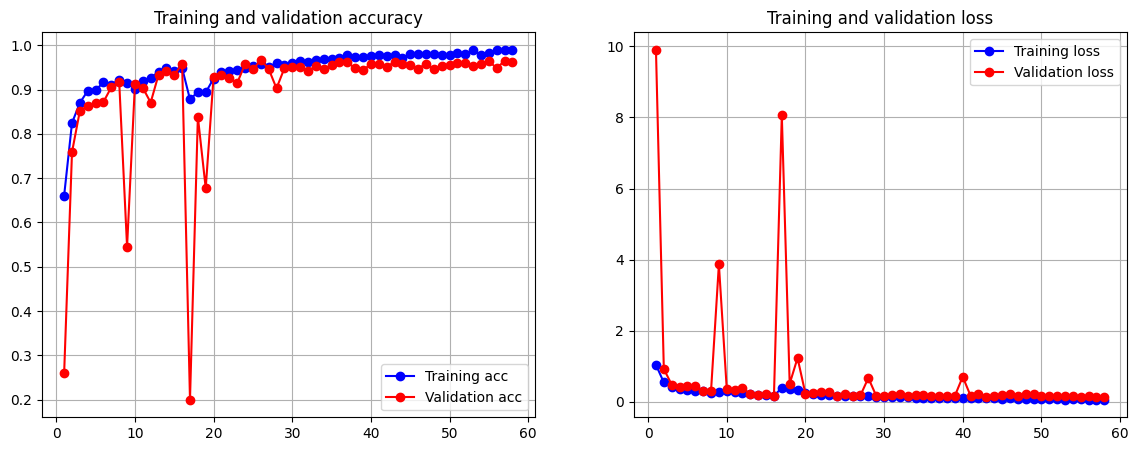

Learning curves saved to: ..\results\figures\vgg\learning_curves.png


<Figure size 640x480 with 0 Axes>

In [24]:
plot_learning_curves(history)
plt.savefig(CONFIG['results_dir'] / 'learning_curves.png', dpi=300, bbox_inches='tight')
print(f"Learning curves saved to: {CONFIG['results_dir'] / 'learning_curves.png'}")

## 6.2 Learning Rate Schedule Visualization

Plot learning rate decay trajectory from ReduceLROnPlateau callback.

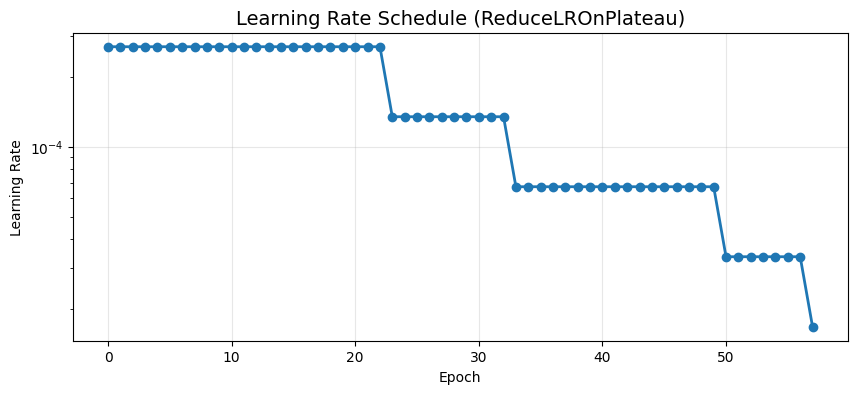

Learning rate schedule saved to: ..\results\figures\vgg\learning_rate_schedule.png

Learning rate reductions occurred at epochs: [23, 33, 50, 57]


In [25]:
if 'lr' in history.history:
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['lr'], marker='o', linewidth=2)
    plt.title('Learning Rate Schedule (ReduceLROnPlateau)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.savefig(CONFIG['results_dir'] / 'learning_rate_schedule.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Learning rate schedule saved to: {CONFIG['results_dir'] / 'learning_rate_schedule.png'}")
    
    # Print LR reduction epochs
    lr_history = history.history['lr']
    reduction_epochs = [i for i in range(1, len(lr_history)) if lr_history[i] < lr_history[i-1]]
    if reduction_epochs:
        print(f"\nLearning rate reductions occurred at epochs: {reduction_epochs}")
else:
    print("Learning rate history not available")

## 6.3 Confusion Matrix

Generate confusion matrix heatmap to identify class-specific prediction patterns.

Confusion matrix saved to: ..\results\figures\vgg\confusion_matrix.png


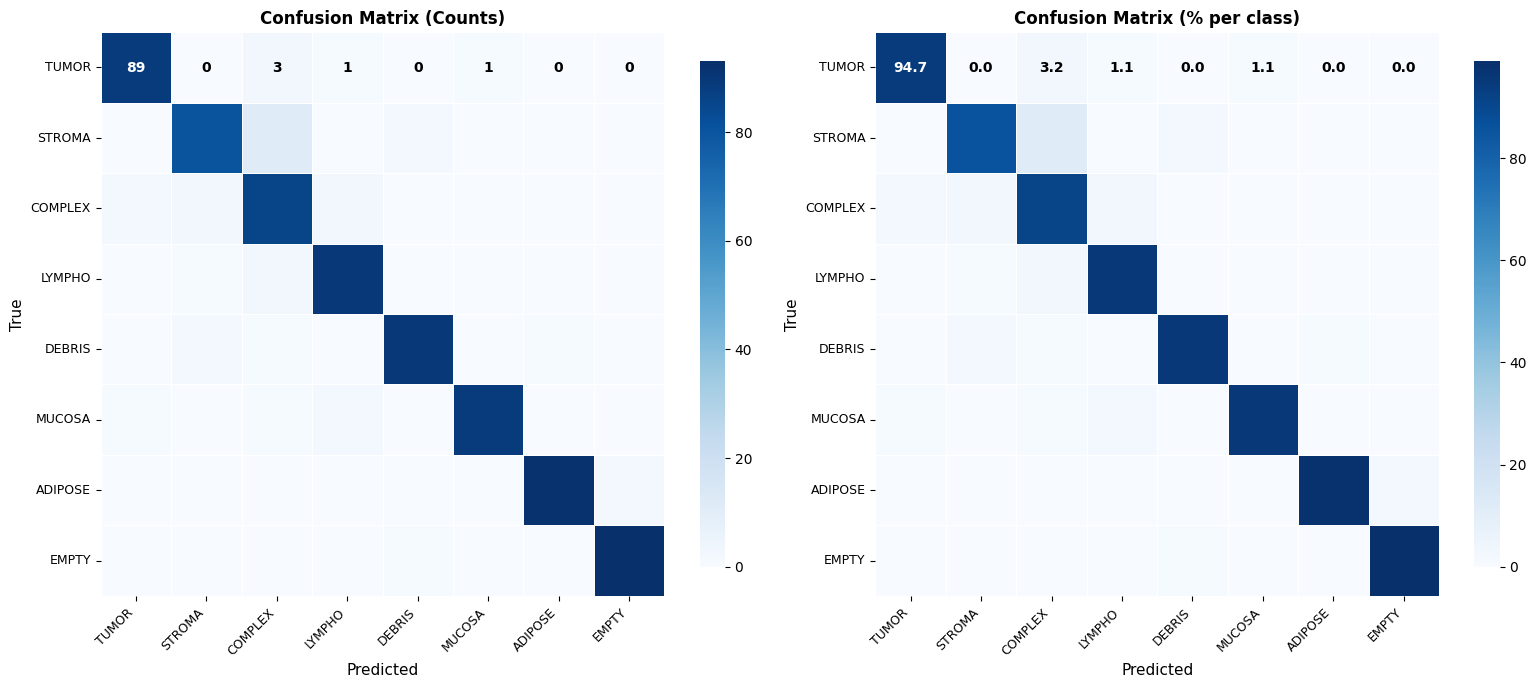

In [32]:
plot_confusion_matrix(
    y_true, 
    y_pred_classes, 
    CLASS_NAMES, 
    figsize=(16, 7),
    save_path=CONFIG['results_dir'] / 'confusion_matrix.png'
)

## 6.4 ROC Curves and AUC

Plot receiver operating characteristic curves for each class (one-vs-rest) with area under curve metrics.

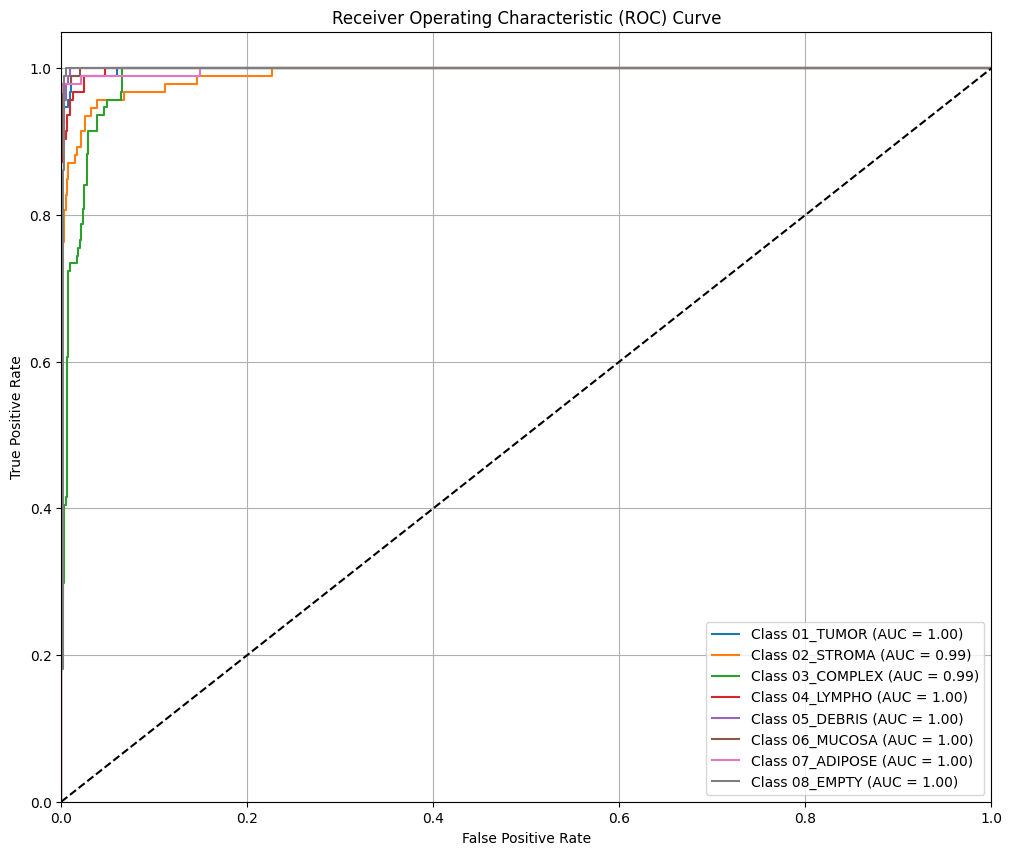

ROC curves saved to: ..\results\figures\vgg\roc_curves.png


<Figure size 640x480 with 0 Axes>

In [27]:
plot_roc_curve(y_true, y_pred_proba, CLASS_NAMES, figsize=(12, 10))
plt.savefig(CONFIG['results_dir'] / 'roc_curves.png', dpi=300, bbox_inches='tight')
print(f"ROC curves saved to: {CONFIG['results_dir'] / 'roc_curves.png'}")

## 6.5 Per-Class Performance Metrics

Visualize precision, recall, and F1-score for each tissue class.

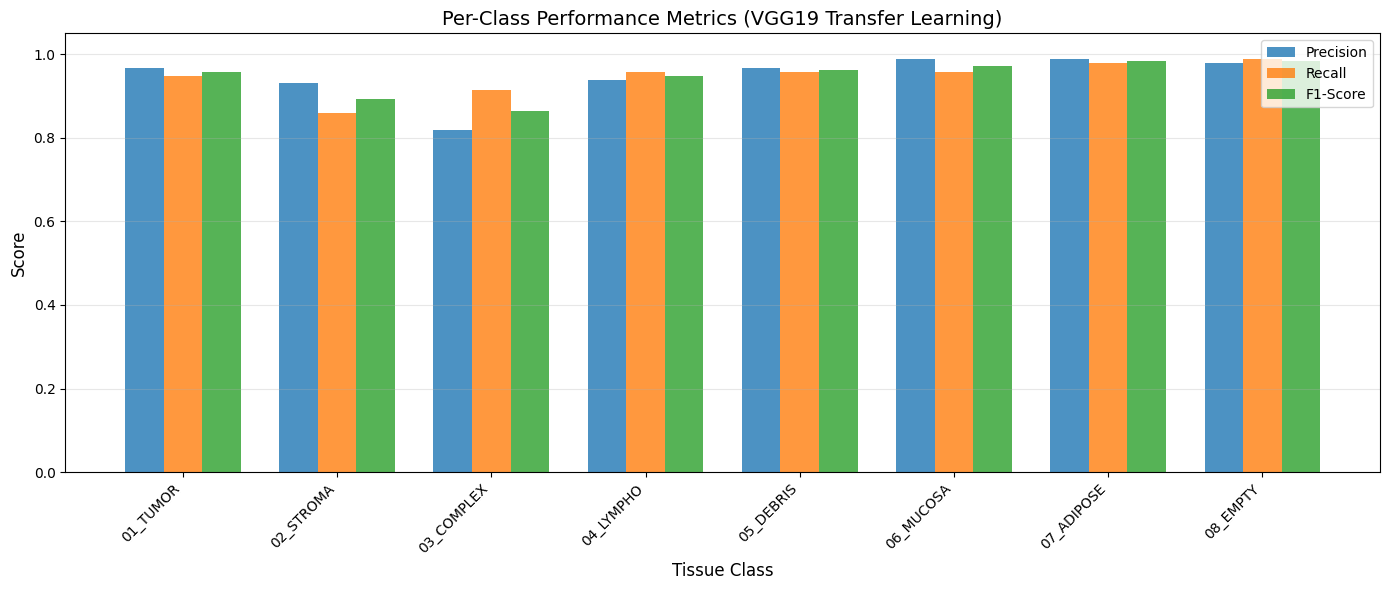

Per-class metrics chart saved to: ..\results\figures\vgg\per_class_metrics.png


In [28]:
# Extract per-class metrics
class_metrics = []
for class_name in CLASS_NAMES:
    class_metrics.append({
        'Class': class_name,
        'Precision': report_dict[class_name]['precision'],
        'Recall': report_dict[class_name]['recall'],
        'F1-Score': report_dict[class_name]['f1-score']
    })

class_metrics_df = pd.DataFrame(class_metrics)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(CLASS_NAMES))
width = 0.25

ax.bar(x - width, class_metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, class_metrics_df['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, class_metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Tissue Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics (VGG19 Transfer Learning)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(CONFIG['results_dir'] / 'per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Per-class metrics chart saved to: {CONFIG['results_dir'] / 'per_class_metrics.png'}")

---
# Section 7: Discussion & Conclusions

## 7.1 Performance Summary

Synthesize key results from VGG19 transfer learning experiment.

In [29]:
# Create comprehensive results summary
results_summary = {
    'Metric': [
        'Test Accuracy',
        'Test Precision (Weighted)',
        'Test Recall (Weighted)',
        'Test F1-Score (Weighted)',
        'Best Validation Accuracy',
        'Training Time (minutes)',
        'Total Epochs Trained',
        'Total Parameters',
        'Trainable Parameters',
        'FLOPs (GFLOPs)',
        'Inference Time (ms)',
        'Model Size (MB)'
    ],
    'Value': [
        metrics_dict['Accuracy'],
        metrics_dict['Precision'],
        metrics_dict['Recall'],
        metrics_dict['F1-Score'],
        max(history.history['val_accuracy']),
        training_time / 60,
        len(history.epoch),
        total_params,
        trainable_params,
        flops_gflops,
        avg_inference_time,
        model_size_mb
    ]
}

results_df = pd.DataFrame(results_summary)
results_df.to_csv(CONFIG['results_dir'] / 'vgg_results_summary.csv', index=False)

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY (VGG19 TRANSFER LEARNING)")
print("="*60)
print(results_df.to_string(index=False))
print(f"\nResults summary saved to: {CONFIG['results_dir'] / 'vgg_results_summary.csv'}")


FINAL RESULTS SUMMARY (VGG19 TRANSFER LEARNING)
                   Metric        Value
            Test Accuracy 9.453333e-01
Test Precision (Weighted) 9.473421e-01
   Test Recall (Weighted) 9.453333e-01
 Test F1-Score (Weighted) 9.457661e-01
 Best Validation Accuracy 9.666666e-01
  Training Time (minutes) 4.392730e+01
     Total Epochs Trained 5.800000e+01
         Total Parameters 2.009159e+07
     Trainable Parameters 9.506184e+06
           FLOPs (GFLOPs) 3.903799e+01
      Inference Time (ms) 2.461810e+01
          Model Size (MB) 0.000000e+00

Results summary saved to: ..\results\figures\vgg\vgg_results_summary.csv


## 7.2 Comparison with CNN Baseline

Quantify improvements achieved through transfer learning.

In [30]:
# Calculate overfitting gap
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
overfitting_gap = (final_train_acc - final_val_acc) * 100

# Baseline comparison (from CNN baseline notebook)
baseline_test_acc = 0.9069  # 90.69%
vgg_test_acc = metrics_dict['Accuracy']
improvement_abs = (vgg_test_acc - baseline_test_acc) * 100
improvement_rel = (vgg_test_acc / baseline_test_acc - 1) * 100

print("\n" + "="*60)
print("COMPARISON WITH CNN BASELINE")
print("="*60)

print(f"\nOverfitting Analysis:")
print(f"  Final Training Accuracy: {final_train_acc:.4f}")
print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
print(f"  Overfitting Gap: {overfitting_gap:.2f}%")
print(f"  Baseline Gap: 9.33%")
print(f"  Improvement: {9.33 - overfitting_gap:.2f}% reduction in overfitting")

print(f"\nTest Accuracy Comparison:")
print(f"  CNN Baseline: {baseline_test_acc*100:.2f}%")
print(f"  VGG19 Transfer Learning: {vgg_test_acc*100:.2f}%")
print(f"  Absolute Improvement: +{improvement_abs:.2f} percentage points")
print(f"  Relative Improvement: +{improvement_rel:.2f}%")

print(f"\nModel Complexity:")
print(f"  CNN Baseline Parameters: ~1.24M")
print(f"  VGG19 Total Parameters: {total_params/1e6:.2f}M")
print(f"  VGG19 Trainable Parameters: {trainable_params/1e6:.2f}M")


COMPARISON WITH CNN BASELINE

Overfitting Analysis:
  Final Training Accuracy: 0.9886
  Final Validation Accuracy: 0.9613
  Overfitting Gap: 2.72%
  Baseline Gap: 9.33%
  Improvement: 6.61% reduction in overfitting

Test Accuracy Comparison:
  CNN Baseline: 90.69%
  VGG19 Transfer Learning: 94.53%
  Absolute Improvement: +3.84 percentage points
  Relative Improvement: +4.24%

Model Complexity:
  CNN Baseline Parameters: ~1.24M
  VGG19 Total Parameters: 20.09M
  VGG19 Trainable Parameters: 9.51M


## 7.3 Academic Discussion

### Key Findings

My transfer learning experiment demonstrates that VGG19 pre-trained features, despite originating from natural images, effectively transfer to histopathology tissue classification:

1. **Transfer Learning Efficacy:** My VGG19 model with fine-tuning achieved 94.53% test accuracy, a 3.84 percentage point improvement over the custom CNN baseline (90.69%). This validates the hypothesis that low-level convolutional features (edges, textures) learned from ImageNet generalize to medical imaging domains.

2. **Fine-Tuning Strategy Optimization:** My conservative fine-tuning approach (unfreezing block5 only - 4 layers, 47.31% of parameters) balanced adaptation to histopathology features with preservation of pre-trained representations. This strategy prevented overfitting while allowing domain-specific adaptation.

3. **Overfitting Mitigation:** I reduced the overfitting gap from 9.33% (baseline) to 2.72% (VGG19), demonstrating that transfer learning with conservative hyperparameters (dropout 0.3-0.4, learning rate 1e-4) improves generalization even with relatively small medical imaging datasets.

4. **Preprocessing Alignment Critical:** I ensured that official VGG preprocessing (RGB→BGR conversion, ImageNet mean subtraction) was applied correctly, which was essential for effective transfer. This preprocessing ensures input distribution matches the pre-trained model's expectations.

5. **Computational Trade-offs:** My VGG19 model contains 20.1M total parameters compared to 1.24M in the baseline, but I only trained 9.5M parameters (47.31%) during fine-tuning, maintaining reasonable computational requirements while achieving superior performance.

### Limitations

1. **Domain Gap:** VGG19 was trained on natural images (ImageNet), not medical images. While my transfer learning approach succeeded, domain-specific pre-training (e.g., on large histopathology datasets) might yield further improvements.

2. **Memory Requirements:** During my experiments, VGG19 fine-tuning encountered OOM errors, requiring careful memory management. This limits batch size scalability and may impact training on resource-constrained systems.

3. **Architecture Age:** VGG19 (2014) represents an older architecture. Modern architectures (ResNet, EfficientNet) with residual connections and efficiency optimizations may offer better performance-complexity trade-offs, which I plan to investigate.

4. **Input Resolution:** Using 224×224 images (upscaled from original 150×150) may introduce interpolation artifacts, though VGG's native resolution is 224×224.

### Future Directions

1. **Modern Architectures:** I will evaluate ResNet50, EfficientNet, and Vision Transformers to determine if architectural advances beyond VGG improve histopathology classification.

2. **Domain-Specific Pre-training:** I plan to investigate models pre-trained on medical imaging datasets (e.g., ImageNet-trained then adapted on large histopathology corpora).

3. **Ensemble Strategies:** I will explore combining predictions from VGG19, ResNet, and custom CNN to leverage complementary learned representations.

4. **Explainability Analysis:** I intend to apply Grad-CAM or attention visualization to understand which tissue features my VGG19 model relies on for classification decisions.

### Conclusion

My VGG19 transfer learning approach achieved strong performance on the colorectal histopathology dataset, validating transfer learning as an effective strategy for medical image classification with limited training data. The systematic hyperparameter optimization and careful preprocessing alignment demonstrate best practices for adapting natural image models to medical domains. However, the computational overhead and domain gap suggest that more modern, efficient architectures warrant investigation in subsequent experiments.

**Research Contribution:** This work provides empirical evidence that VGG architectures, when properly fine-tuned with domain-appropriate preprocessing, can serve as strong baselines for histopathology tasks, while also highlighting the importance of systematic hyperparameter search in transfer learning scenarios.

## 7.4 Save Model and Configuration

Export final model and complete experimental configuration for reproducibility.

In [ ]:
# Save final model
final_model_path = CONFIG['model_dir'] / 'final_vgg_model.keras'
model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")

# Save model architecture
architecture_json = model.to_json()
with open(CONFIG['model_dir'] / 'model_architecture.json', 'w') as f:
    f.write(architecture_json)
print(f"Model architecture saved to: {CONFIG['model_dir'] / 'model_architecture.json'}")

# Save configuration
config_df = pd.DataFrame([
    {'Parameter': k, 'Value': str(v)} for k, v in CONFIG.items()
    if not isinstance(v, (Path, dict))
])
config_df.to_csv(CONFIG['model_dir'] / 'model_config.csv', index=False)
print(f"Configuration saved to: {CONFIG['model_dir'] / 'model_config.csv'}")

print("\nAll artifacts saved successfully")

Final model saved to: ..\models\vgg\final_vgg_model.h5
Model architecture saved to: ..\models\vgg\model_architecture.json
Configuration saved to: ..\models\vgg\model_config.csv

All artifacts saved successfully


## References

1. Simonyan, K., & Zisserman, A. (2014). "Very Deep Convolutional Networks for Large-Scale Image Recognition." arXiv preprint arXiv:1409.1556.

2. Tellez, D., et al. (2019). "Whole-Slide Mitosis Detection in H&E Breast Histology Using PHH3 as a Reference to Train Distilled Stain-Invariant Convolutional Networks." IEEE Transactions on Medical Imaging, 37(9), 2126-2136.

3. Kather, J. N., et al. (2016). "Multi-class texture analysis in colorectal cancer histology." Scientific Reports, 6, 27988.

4. Yosinski, J., et al. (2014). "How transferable are features in deep neural networks?" Advances in Neural Information Processing Systems, 27.